##Abalon - определяем возраст морского ушка.

#Общее исследование данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://github.com/bakenbardich/eda_and_dev_tools/raw/main/abalone.csv')

In [3]:
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,NaN,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
df.shape

(4177, 9)

В датасете 4177 строки и 9 столбцов

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4078 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4078 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4127 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


Пропущенные значения Diameter, Whole weight и Shell,заменим их на медианные.

In [6]:
df['Diameter'].fillna(df['Diameter'].median(), inplace=True)
df['Whole weight'].fillna(df['Whole weight'].median(), inplace=True)
df['Shell weight'].fillna(df['Shell weight'].median(), inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [10]:
df[df.duplicated()]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings


Повторяющиеся обьекты отсутствуют.

#Исследуем корреляцию

График корреляции pearson


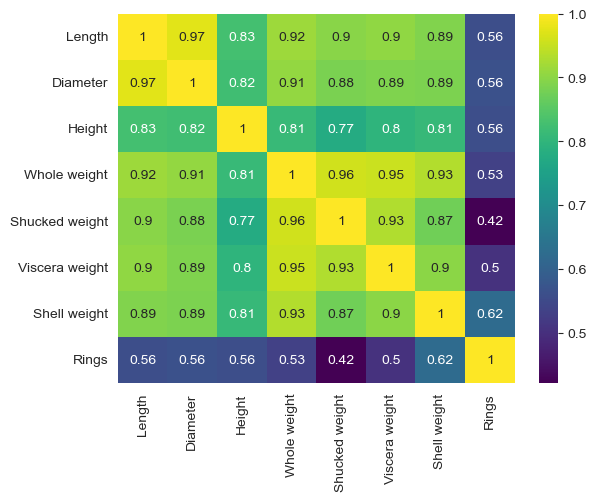

График корреляции spearman


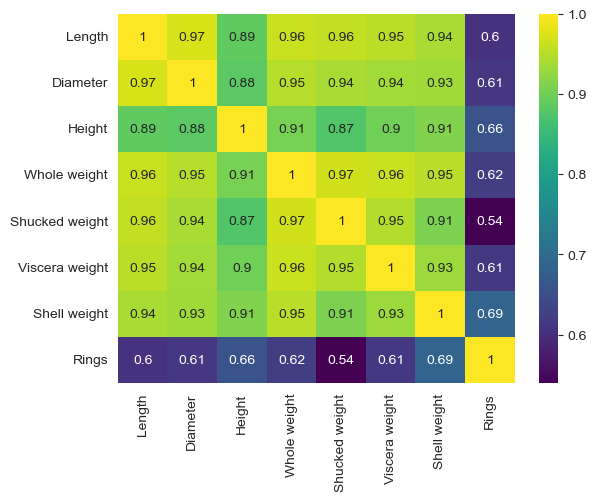

График корреляции kendall


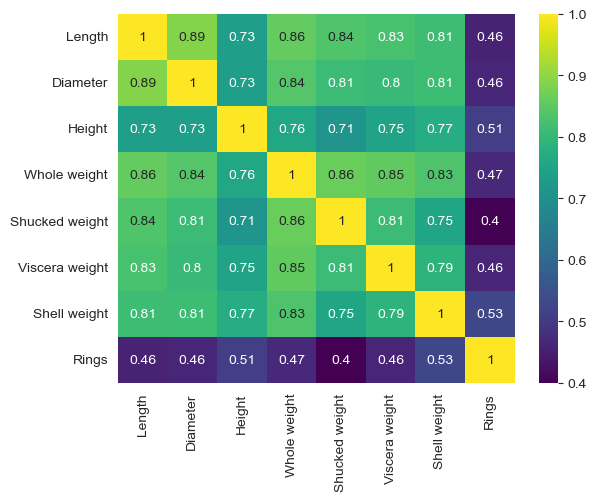

In [9]:
for i in ['pearson','spearman','kendall']:
    cr =df.corr(numeric_only=True,method=i)
    sns.heatmap(cr,annot=True,cmap='viridis')
    print(f'График корреляции {i}')
    plt.show()

Во всех методаx прослеживается сильная корреляция фичей междуй собой, что может создать проблему мультиколлинеарности при построении моделей ML, особенно линейных. В таких случаях может потребоваться удаление некоторых признаков или применение методов регуляризации.
Корреляция фичей с таргетом равномерная на уровне 0.5

Рассмотрим как коррелирует единственная категориальная фича с таргетом с помощью ANOVA

In [22]:
rings = df[['Sex','Rings']]

In [24]:
rings_group_list = rings.groupby('Sex')['Rings'].apply(list)

In [25]:
rings_group_list

Sex
F    [9, 20, 16, 19, 14, 10, 10, 10, 12, 9, 10, 11,...
I    [7, 8, 7, 10, 5, 5, 4, 7, 6, 8, 4, 6, 7, 9, 7,...
M    [15, 7, 10, 9, 10, 11, 12, 7, 9, 11, 12, 15, 1...
f    [11, 18, 14, 10, 10, 10, 14, 8, 10, 14, 9, 3, ...
Name: Rings, dtype: object

In [26]:
from scipy.stats import f_oneway

In [27]:
AnovaResults = f_oneway(*rings_group_list)

print('P-Value for Anova is: ', AnovaResults[1])

if AnovaResults[1] >= 0.05:
    print('Features are NOT correlated')
else:
    print('Features are correlated')

P-Value for Anova is:  1.8545900446585218e-185
Features are correlated


In [28]:
Data = []

for c1 in df.columns:
    for c2 in df.columns:
        if df[c1].dtype == 'object' and df[c2].dtype != 'object':
            CategoryGroupLists = df.groupby(c1)[c2].apply(list)
            AnovaResults = f_oneway(*CategoryGroupLists)

            if AnovaResults[1] >= 0.05:
                Data.append({'Category' : c1, 'Numerical' : c2, 'Is correlated' : 'No'})
            else:
                Data.append({'Category' : c1, 'Numerical' : c2, 'Is correlated' : 'Yes'})

AnovaRes = pd.DataFrame.from_dict(Data)
AnovaRes

,Category,Numerical,Is correlated
0,Sex,Length,Yes
1,Sex,Diameter,Yes
2,Sex,Height,Yes
3,Sex,Whole weight,Yes
4,Sex,Shucked weight,Yes
5,Sex,Viscera weight,Yes
6,Sex,Shell weight,Yes
7,Sex,Rings,Yes


Взаимосвязь между SEX и таргетом прослеживаеться , так же как и с остальными числовыми фичами

Распределение таргета и фичей 

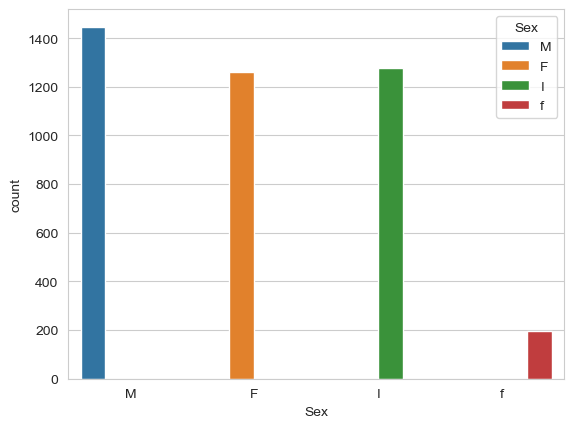

In [11]:
sns.countplot(data=df,x = 'Sex',hue=df['Sex']);

В описании три уникальных значения SEX, скорее опечатка, поменяем f на F

In [ ]:
df.loc[df['Sex'] == 'f', 'Sex'] = 'F'

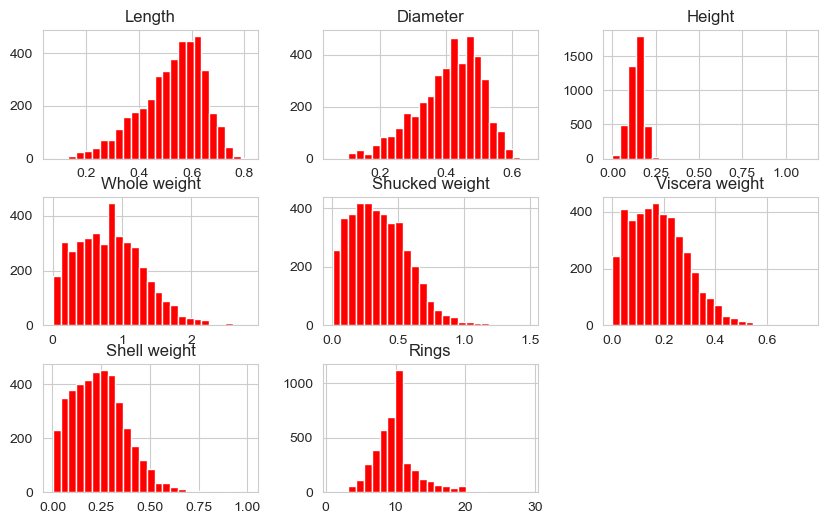

In [31]:
df.hist(bins=25,figsize=(10,6),color='r');

Целевой возраст приближен к нормальному распределению, хоть и имеется небольшой хвост справа.
В целом, нормальное распределение признака может облегчить анализ и интерпретацию данных, но необходимо оценивать его применимость к конкретному набору данных и использовать соответствующие методы для проверки и обработки данных, если они не соответствуют нормальному распределению.


Так как у нас таргет-непрерывная переменная, давайте посмотрим на диаграммы рассеивания и оценим, как каждый признак влияет на переменную и есть ли вообще связь.

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


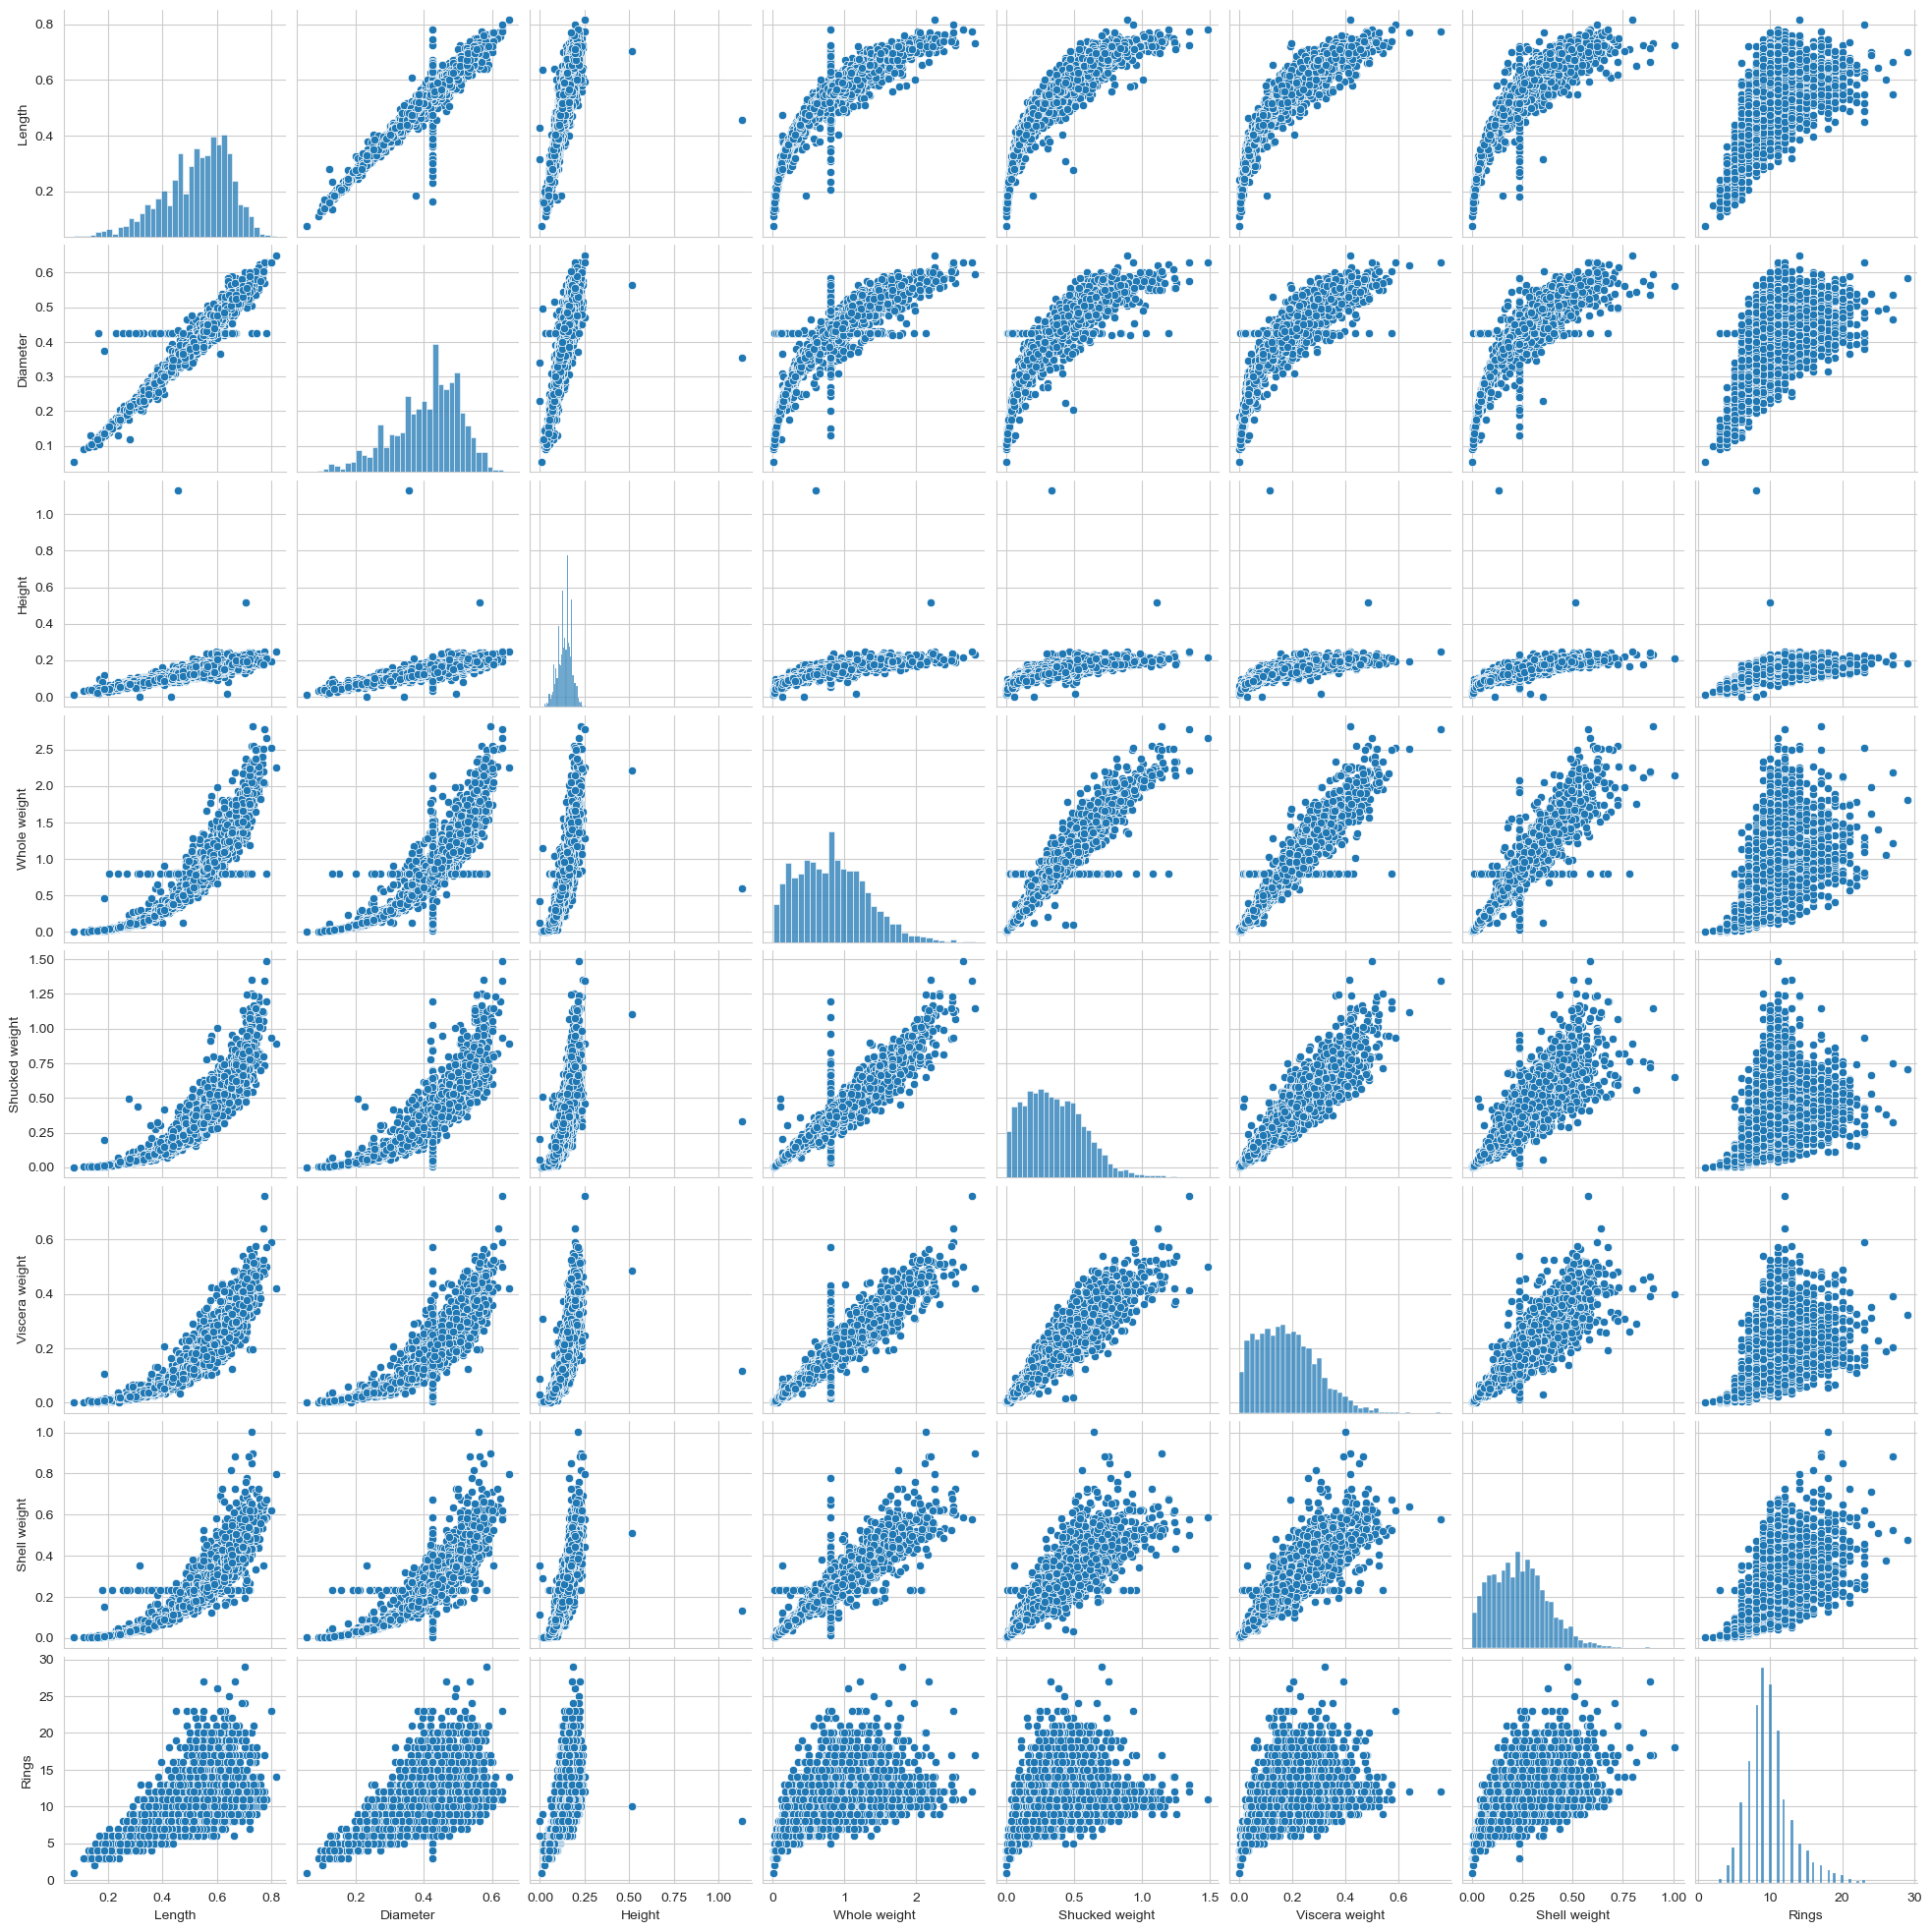

In [11]:
sns.pairplot(data=df);

Возраст морских ушек увеличивается с увеличением их длины, диаметра, высоты и веса.
Общий вес почти линейно изменяется в зависимости от всех других характеристик, кроме возраста.
Высота имеет наименьшую линейность с остальными функциями.
Возраст больше всего коррелирует с весом раковины.
Возраст меньше всего коррелирует со сбросом веса.

Размножим датасет для проведения тестов с Polars

In [43]:
df_big = df.copy()

for i in range(400):
    df_big = pd.concat([df_big, df])

df_big.to_csv("big.csv", index=False)
df_big.shape, df.shape

((1674977, 9), (4177, 9))

In [41]:
import polars as pl

In [44]:
%%time
df_pl = pl.read_csv("big.csv")

CPU times: total: 906 ms
Wall time: 197 ms


In [45]:
%%time
df_ = pd.read_csv("big.csv")

CPU times: total: 1.34 s
Wall time: 1.52 s


In [47]:
%%time
df_.query('Rings > 10')

CPU times: total: 62.5 ms
Wall time: 75.1 ms


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.3300,20
7,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.2600,16
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.3200,19
10,F,0.525,0.380,0.140,0.6065,0.1940,0.1475,0.2100,14
...,...,...,...,...,...,...,...,...,...
1674948,M,0.770,0.605,0.175,2.0505,0.8005,0.5260,0.3550,11
1674960,F,0.585,0.475,0.165,1.0530,0.4580,0.2170,0.3000,11
1674961,F,0.585,0.455,0.170,0.9945,0.4255,0.2630,0.2845,11
1674972,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11


In [50]:
%%time
df_pl.filter(pl.col('Rings')>10)

CPU times: total: 406 ms
Wall time: 89.2 ms


Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
str,f64,f64,f64,f64,f64,f64,f64,i64
"""M""",0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
"""F""",0.53,0.415,0.15,0.7775,0.237,0.1415,0.33,20
"""F""",0.545,0.425,0.125,0.768,0.294,0.1495,0.26,16
"""F""",0.55,0.44,0.15,0.8945,0.3145,0.151,0.32,19
"""F""",0.525,0.38,0.14,0.6065,0.194,0.1475,0.21,14
…,…,…,…,…,…,…,…,…
"""M""",0.77,0.605,0.175,2.0505,0.8005,0.526,0.355,11
"""F""",0.585,0.475,0.165,1.053,0.458,0.217,0.3,11
"""F""",0.585,0.455,0.17,0.9945,0.4255,0.263,0.2845,11


In [53]:
%%time
df_.groupby('Sex').agg({'Diameter' : 'mean', 'Height' : 'max'})

CPU times: total: 109 ms
Wall time: 117 ms


,Diameter,Height
Sex,,
F,0.453102,1.130
I,0.327924,0.220
M,0.437728,0.515
f,0.416754,0.230


In [54]:
%%time
df_pl.group_by('Sex').agg([pl.mean('Diameter'),pl.max('Height')])

CPU times: total: 125 ms
Wall time: 101 ms


Sex,Diameter,Height
str,f64,f64
"""I""",0.327924,0.22
"""M""",0.437728,0.515
"""f""",0.416754,0.23
"""F""",0.453102,1.13


Очевидно ,что Polars классная библиотека=)